# Recurrent Neural Network Homework

This is the 4th assignment for CAP 4630 and we will implement a basic RNN network and an LSTM network with Pytorch to solve two problems. \
You will use **"Tasks"** and **"Hints"** to finish the work. **(Total 60 points, with extra 10 bonus points)** \
You may use Machine Learning libaries like Scikit-learn for data preprocessing.

**Task Overview:**
- Implement a basic RNN network to solve time series prediction
- Implement an LSTM network to conduct sentiment analysis

## 1 - Implement a RNN model to predict time series##
### 1.1 Prepare the data (10 Points)

Prepare time series data for deep neural network training.

**Tasks:**
1. Load the given train and test data: "train.txt" and "test.txt". **(2.5 Points)**
2. Generate the **TRAIN** and **TEST** labels. **(2.5 Points)**
3. Normalize the **TRAIN** and **TEST** data with sklearn function "MinMaxScaler". **(2.5 Points)**
4. **PRINT OUT** the **TEST** data and label. **(2.5 Points)**

**Hints:**  
1. The length of original train data is 113 which starts from **"1949-01"** to **"1958-05"**. The length of original test data is 29, which starts from **"1958-07"** to **"1960-11"**.
2. Set the data types of both train and test data to "float32".
3. Use **past 12** datapoints as input data X to predict the **next 1** datapoint as Y, which is the 'next token prediction'. The time window will be 12.
4. The first 3 **TRAIN** data and label should be:

- trainX[0] = [[0.02203858 &nbsp; 0.03856748 &nbsp; 0.077135 &nbsp;  0.06887051 &nbsp; 0.04683197 &nbsp; 0.08539945 &nbsp; 0.12121212 &nbsp; 0.12121212 &nbsp; 0.08815429 &nbsp; 0.04132232 &nbsp; 0.    &nbsp; 0.03856748]]
- trainY[0] = [0.03030303]

- trianX[1] = [[0.03856748 &nbsp; 0.077135 &nbsp;  0.06887051 &nbsp; 0.04683197  &nbsp; 0.08539945  &nbsp; 0.12121212  &nbsp; 0.12121212  &nbsp; 0.08815429  &nbsp; 0.04132232  &nbsp; 0.     &nbsp;  0.03856748   &nbsp; 0.03030303]]
- trainY[1] = [0.06060606]

- trainX[2] =  [[0.077135 &nbsp;  0.06887051 &nbsp; 0.04683197 &nbsp; 0.08539945 &nbsp; 0.12121212 &nbsp; 0.12121212 &nbsp; 0.08815429 &nbsp; 0.04132232 &nbsp; 0.    &nbsp;     0.03856748 &nbsp; 0.03030303 &nbsp; 0.06060606]]
- trainY[2] = [0.10192838]

5. Apply the MinMaxScaler to both the train and test data.\
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [50]:
#Name: Zachary Hull
#PID: 5062063
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

trainfile = '/content/drive/MyDrive/train.txt'
testfile = '/content/drive/MyDrive/test.txt'

# Step 1. Use pandas to read training and testing from txt file. (2.5 pts)
train = read_csv(trainfile, usecols=["Passengers"])
test = read_csv(testfile, usecols=["Passengers"])

train = train.astype(np.float32)
test = test.astype(np.float32)

# Step 2. Normalize training and test data into [0, 1]. (2.5 pts)
scaler = MinMaxScaler(feature_range=(0,1))
train_norm = scaler.fit_transform(train)
test_norm = scaler.transform(test)

# Step 3. Create a training and test datasets. (2.5 pts)
def newdataset(data):
  x, y = [], []
  for i in range(len(data) - 12):
    x.append(data[i:(i + 12)])
    y.append(data[(i + 12)])
  return np.array(x), np.array(y)

trainX, trainY = newdataset(train_norm)
testX, testY = newdataset(test_norm)


# Step 4. Print out the shape of data. (2.5 pts)
print("TrainX shape: ", trainX.shape)
print("TrainY shape: ", trainY.shape)
print("TestX shape: ", testX.shape)
print("TestY shape: ", testY.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TrainX shape:  (101, 12, 1)
TrainY shape:  (101, 1)
TestX shape:  (17, 12, 1)
TestY shape:  (17, 1)


### 1.2 - Build the RNN model (20 Points) ##


Build a RNN model with RNN cell.

**Tasks:**
1. Build an RNN model with 1 RNN layer and 1 Linear layer, with RNN's hidden size to be 4.  **(10 Points)**
2. Initialize model, optimizer and criterion. **(5 Points)**
3. Train the model for **1000** epochs with **batch_size = 10** and **print out the average traning loss for every 100 epochs**. **(5 Points)**

**Hints:**  
1. You can use **nn.RNN** to specify RNN cells.
2. Use loss function (criterion) **MSELoss()** and select **Adam** optimizer with **learning_rate=0.005** and other default settings.

In [41]:
import torch.nn as nn

# Complete the model architecture (10 pts)
class RNN(nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
       super(RNN, self).__init__()
       self.hidden_size = hidden_size
       self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
       self.fc = nn.Linear(hidden_size, output_size)

     def forward(self, x):
        if x.dim() == 4:
            x = x.view(-1, x.size(2), x.size(3))

        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Create an instance of model, optimizer and criterion. (5 pts)
model = RNN(1, 4, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
batch_size = 10

train_data = torch.tensor(trainX)
train_label = torch.tensor(trainY)


# Train the RNN Model for 1000 epoch and print out the training loss for every 100 epochs. (5 pts)
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, train_label)
    loss.backward()


    optimizer.step()

    pred = output.argmax(dim=1, keepdim=True)


    if epoch % 100 == 0:
      print(f'Epoch [{epoch}/1000], loss: {loss.item(): .4f}')

print(f'Epoch [1000/1000], loss: {loss.item(): .4f}')


Epoch [0/1000], loss:  0.3275
Epoch [100/1000], loss:  0.0097
Epoch [200/1000], loss:  0.0075
Epoch [300/1000], loss:  0.0063
Epoch [400/1000], loss:  0.0055
Epoch [500/1000], loss:  0.0050
Epoch [600/1000], loss:  0.0048
Epoch [700/1000], loss:  0.0046
Epoch [800/1000], loss:  0.0045
Epoch [900/1000], loss:  0.0044
Epoch [1000/1000], loss:  0.0044


### 1.3 Evaluate Predictive Model Performance (**Bonuse point 10 Points**)

Predict datapoints with the observed datapoints and trained model.

**Tasks:**
1. Make prediction on train and test datapoints with the obtained model in section 1.2. **(2 Points)**
2. Denormalize the prediction results back to original scale with the scaler.(scaler.inverse_transform function) **(3 Points)**
3. Calculate root mean squared error (RMSE) and **print out** the error for **both TRAIN and TEST**. **(3 Points)**
4. **Plot** the **TEST** label and prediction. **(2 Points)**


**Hints:**  
1. Scale back the predictions with the build-in function "scaler.inverse_transform".\
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.inverse_transform
2. The plot for validation is shown below (observation test data are blue and prediction results are orange):
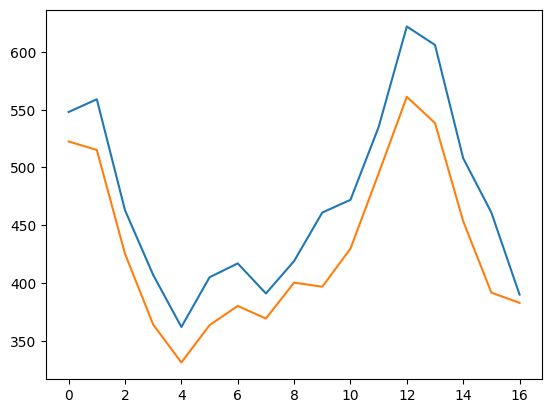

<span style="color:magenta">
    The corresponding figures could be different from the one above, but should be reasonable.**
</span>


Train error: 260.64544677734375
Test error: 457.9433898925781


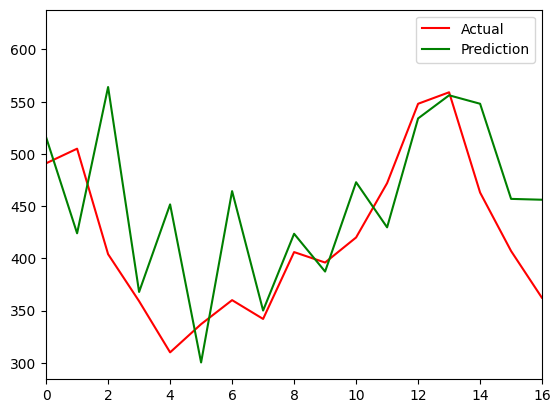

In [49]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Step 1. Inference above model on training and testing data. (2 pts)
test_data = torch.tensor(testX)

train_pred = model(train_data)
test_pred = model(test_data)
# Step 2. Denomalization. (3 pts)
train_denorm = scaler.inverse_transform(train_pred.detach().numpy())
test_denorm = scaler.inverse_transform(test_pred.detach().numpy())

# Step 3. Calculate root mean squared error for training and testing and print. (3 pts)
train_rsme = np.sqrt(mean_squared_error(trainY, train_denorm))
test_rsme = np.sqrt(mean_squared_error(testY, test_denorm))
print(f"Train error: {train_rsme}")
print(f"Test error: {test_rsme}")

# Step 4. Plot the predictions. (2 pts)
plt.plot(test, color="red", label="Actual")
plt.plot(test_denorm, color="green", label="Prediction")
plt.xlim(0,16)
plt.legend()
plt.show()

## 2 - Use LSTM model to conduct sentiment analysis ##

### 2.1 Prepare the data (10 Points) ###
Conduct sentiment analysis using IMDB data with reccurent neural network. Make prediction on sentiment (positive/negative) as a binary classification.
More details can be found here, https://keras.io/api/datasets/imdb/

**Tasks:**
1. Load the data from IMDB review dataset and **print out** the lengths of sequences. **(5 Points)**
2. Preprocess review data to meet the network input requirement by specifying **number of words=1000**, setting **the analysis length of the review = 100**, and **padding the input sequences**. **(5 Points)**

**Hints:**  
1. You may load the IMDB data with keras.datasets.imdb.load_data(num_words=max_features). Here, max_features is set to **1000**.
2. You may use keras.preprocessing.sequence.pad_sequences(x_train, maxlen) to pad the input sequences and set maxlen to **100**.

**Note:**\
We train the build LSTM-based model with ALL training data; the **validation set** (aka **development set**) is set with the **testing set** for model evaluation. This split is common in the application with limited sampled observation data, like NLP problems.

In [2]:
import torch
import random
import numpy as np

from keras.preprocessing import sequence
from keras.datasets import imdb

# Step 1. Load IMDB dataset from keras. (5 pts)
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
    num_words=1000,
    skip_top=0,
    maxlen=100,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)

print("X train length: ", len(x_train))
print("X test length: ", len(x_test))
print("Y train length: ", len(y_train))
print("Y test length: ", len(y_test))

# Step 2. Preprocess the sequences with padding (5 pts)
x_train_pad = sequence.pad_sequences(x_train, maxlen=100)
x_test_pad = sequence.pad_sequences(x_test, maxlen=100)


17464789/17464789 [==============================] - 1s 0us/step
X train length:  2773
X test length:  2963
Y train length:  2773
Y test length:  2963


### 2.2 - Design and train LSTM model (20 Points) ###

Build a LSTM model.

**Tasks:**
1. Build the LSTM model with **1 embedding layer**, **1 LSTM layer**, and **1 Linear layer**. The embedding vector is specified with the dimension of **8**. **(10 Points)**
2. Create LSTM model with **Adam** optimizer, **binary_crossentropy** loss function (BCELoss()). **(5 Points)**  
3. Train the LSTM model with **batch_size=64 for 10 epochs** and report **training and validation accuracies over epochs**. You need to use TensorDataset and DataLoader to split the data into batches with batch_size and shuffle the data. **(5 Points)**
4. **Print out** best validation accuracy. **(5 Points)**



**Hints:**  
1. Set input dimension to **1000** and output dimension to **8** for embedding layer.
2. You need to initialize hidden(h) and cell(c) for the lstm and always use h and c as input to your lstm layer. (For performance)
3. Set **hidden dimension = 8** for LSTM layer.
4. Use only the last layer as the input of linear layer (For performance)
5. Set activation function to **sigmoid** for Linear layer.
6. You may have some trouble with the data dimension, please consider using squeeze or unsqueeze to make two data have the same dimension.
7. Write a constructor with many configurations (number of layers, embedding dimension...) could save you a lot of time for the bonus questions since you can reuse the code here.

In [12]:
import torch
import torch.nn as nn

# Complete LSTM model architecture. (20 pts)
class LSTMClassifier(nn.Module):
    def __init__(self, max_features, embedding_dim, hidden_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.embeddings = nn.Embedding(max_features, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_layers)

    def forward(self, sentence):
        sentence = self.embeddings(sentence)
        sentence, _ = self.lstm(sentence)
        sentence = self.classifier(sentence)
        return sentence

# Create an instance of LSTM model, an adam optimizer and BCE loss. (5 pts)
max_features = 1000
embedding_dim = 8
hidden_dim = 8
num_layers = 1
batch_size = 64

x_train_tensor = torch.tensor(x_train_pad)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test_pad)
y_test_tensor = torch.tensor(y_test)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model2 = LSTMClassifier(max_features, embedding_dim, hidden_dim, num_layers)
criterion2 = nn.BCELoss()
optimizer2 = torch.optim.Adam(model2.parameters())


# Train the model, print out the loss. (5 pts)
for epoch in range(10):
  model2.train()
  running_loss=0.0
  for var1, var2 in train_loader:
    optimizer2.zero_grad()
    output = model2(var1)
    var2 = var2.unsqueeze(1).repeat(1, 100).float()
    output = torch.sigmoid(output)
    loss = criterion2(output.squeeze(), var2)
    loss.backward()
    optimizer2.step()
    running_loss = loss.item()
  print(f"Epoch {epoch+1}: Loss {running_loss / len(train_loader):.4f}")


# Print out the best validation accuracy. (5 pts)
best_acc = 0.0
model2.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for val3, val4 in test_loader:
    output = model2(val3)
    pred = torch.round(torch.sigmoid(output))

    correct += (pred == val4).sum().item()
    total += val4.size(0)

  accuracy = correct / total
  if accuracy > best_acc:
    best_acc = accuracy
  print(f"Best Validation Accuracy: {best_acc:.4f}")

Epoch 1: Loss 0.0153
Epoch 2: Loss 0.0148
Epoch 3: Loss 0.0146
Epoch 4: Loss 0.0145
Epoch 5: Loss 0.0144
Epoch 6: Loss 0.0144
Epoch 7: Loss 0.0144
Epoch 8: Loss 0.0144
Epoch 9: Loss 0.0143
Epoch 10: Loss 0.0143
Best Validation Accuracy: 3445.7361


# Reinforcement Learning

This is the 5th assignment for CAP 4630 and we will train an AI-based explorer to play a game by reinforcement learing. As domestrated below, in this game, the treasure (denoted by T) is on the right-most and the explorer (denoted by o) will learn to get the treasure by moving left and right. The explorer will be rewarded when it gets the treasure.  After serveral epoches, the explorer will learn how to get the treasure faster and finally it will go to the treasure by moving to right directly. \

You will use **"Tasks"** and **"Hints"** to finish the work. **(Total 60 points, with extra 10 bonus points)** \

Episode 1, Step1: o----T   \
... \
Episode 1, Step6: ---o-T   \
... \
Episode 1, Step10: -o---T \
... \
Episode 1, Step15: ----oT (finished) \

You will use **"Tasks"** and **"Hints"** to finish the work. **(Total 100 Points)**. Additionally, you have the opportunity to earn **(extra bonus 10 points)** for extra challenges. \

**Task Overview:**
- Train the explorer getting the treasure quickly through Q-learning method

## 1 Achieve Q-learning method ##
### 1.1 Model Preparation **(5 Points)**

Import useful packages and prepare hyperpaprameters for Q-learning methods.

**Tasks:**
1. Import numpy and rename it to np.
2. Import pandas and rename it to pd.
3. Import the library "time"
4. Set the parameter as suggested

**Hints:**
1. For your first trial, you may set as it is
2. You may explore other possibilities here when you complete the whole homework

In [14]:
#import packages here
import time
import pandas as pd

N_STATES = 6   # the width of 1-dim world
ACTIONS = ['left', 'right']     # the available actions to use
EPSILON = 0.9   # the degree of greedy (0＜ε＜1)
ALPHA = 0.1     # learning rate (0＜α≤1)
GAMMA = 0.9    # discount factor (0＜γ＜1)
MAX_EPOCHES = 13   # the max epoches
FRESH_TIME = 0.3    # the interval time

### 1.2 Q table **(5 Points)**

Q table is a [states * actions] matrix, which stores Q-value of taking one action in that specific state. For example, the following Q table means in state s3, it is more likely to choose a1 because it's Q-value is 5.31 which is higher than Q-value 2.33 for a0 in s3(refer to Lecture slides 16, page 35).
![](https://drive.google.com/uc?export=view&id=1WGh7NYyYw6ccrxbDVdfbJmb_IhBfUyFf)

**Tasks:**
1. define the build_q_table function
2. **Print Out** defined Q-table. The correct print information should be:

|     | left | right |
|-----|------|-------|
| 0   | 0.0  | 0.0   |
| 1   | 0.0  | 0.0   |
| 2   | 0.0  | 0.0   |
| 3   | 0.0  | 0.0   |
| 4   | 0.0  | 0.0   |
| 5   | 0.0  | 0.0   |


    

**Hints:**
1. Using pd.DataFrame to define the Q-table.(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
2. Initialize the Q-table with all zeros.

In [15]:
#define the function here
def build_q_table(n_states, actions):
  table = pd.DataFrame(data=0.0, index=range(n_states), columns=actions)
  return table
N_STATES = 6
ACTIONS = ['left', 'right']
q_table = build_q_table(N_STATES, ACTIONS)
print(q_table)

   left  right
0   0.0    0.0
1   0.0    0.0
2   0.0    0.0
3   0.0    0.0
4   0.0    0.0
5   0.0    0.0


### 1.3 Define action **(10 Points)**

In this section, we are going to define how an actor picks the actions. We introduce ε-greedy (In lecture slide 16, page 35). In the initial exploring stage, the explorer knows little about the environment. Therefore, it is better to explore randomly instead of greedy. ε-greedy is the value to control the degree of greedy. It can be changed with time lapsing. In this homework, we set it as fixed value EPSILON = 0.9. You can change it to explore the final effect.

**Tasks:**
1. define the choose_action function
2. **Print Out** sample action. The sampled action should be "left" or "right".

**Hints:**
1. You need to define two cases: 1) non-greedy (i.e., random); 2) greedy.
2. Non-greedy should occupy (1-ε) senario while greedy should occupy ε senario. In this case, it means Non-greedy occupys 10% senario while greedy occupys 90% senario. (you could implement it by comparing a random number ranging from 0 to 1 with ε. **Numpy provides a function capable of generating a random number from a uniform distribution.**)
3. In the non-greedy pattern, the actor should choose the actions randomly.
4. In the greedy pattern, the actor should choose the higher Q-value action.
5. Don't forget the initial state which means all Q-value are zero and actor cannot choose greedily. You can treat it as non-greedy pattern.

In [38]:
#define the function here
#Given state and Q-table, choose action
def choose_action(state, q_table):
      # pick all actions from this state
    if np.random.uniform() < 1 - EPSILON or np.sum(q_table.loc[state, :]) == 0:  # non-greedy or non-explored
        action_name = np.random.choice(q_table.columns)
    else:
        action_name = q_table.loc[state, :].idxmax()    # greedy
    return action_name

sample_action = choose_action(0, q_table)
print(sample_action)

right


### 1.4 Interact with the environment **(20 Points)**

In this section, we need to give a feedback for our previous action, which means getting reward (R) for next state (S_next) based on current state (S_current) and action (A). In this problem, we get reward R=1 if we move to the treasure T spot, otherwise, we get R=0.

**Tasks:**
1. define get_env_feedback function
**Hints:**
1. This function contains two parameters S_current and A(ction), and return S_next and R(eward).
2. You need to consider two different senarios: 1) A = right; 2) A = left.
3. In the above two senarios, you need to consider the boundary, next state and rewards.
4. The update_env function is given to show changes for different steps in different episodes.
5. The validation for S_current and Action is shown below.

- S_current=0, sample_action = 'right', sample_feedback=(1,0)
- S_current=3, sample_action = 'right', sample_feedback=(4,0)
- S_current=4, sample_action = 'right', sample_feedback=('terminal', 1)
- S_current=0, sample_action = 'left', sample_feedback=(0,0)
- S_current=3, sample_action = 'left', sample_feedback=(2,0)
- S_current=4, sample_action = 'left', sample_feedback=(3, 0)

In [28]:
#define the function here
def get_env_feedback(S_current, A):
    # This is how agent will interact with the environment
    treasure = 4
    if A == 'right':    # move right
      if S_current == treasure - 1:
        S_next = 'terminal'
        R = 1
      else:
        S_next = S_current + 1
        R = 0
    else:   # move left
      if S_current == 0:
        S_next = S_current
        R = 0
      else:
        S_next = S_current - 1
        R = 0
    return S_next, R

sample_action = 'left'
S_current = 4
sample_feedback = get_env_feedback(S_current, sample_action)
print(sample_feedback)

(3, 0)


In [29]:
def update_env(S, episode, step_counter):
    # This is how environment be updated
    env_list = ['-']*(N_STATES-1) + ['T']   # '---------T' our environment
    if S == 'terminal':
        interaction = '  Episode %s: total_steps = %s' % (episode+1, step_counter)
        print('{}\n'.format(interaction), end='')
        time.sleep(2)
    else:
        env_list[S] = 'o'
        interaction = ''.join(env_list)
        print('\r{}'.format(interaction), end='')
        time.sleep(FRESH_TIME)

### 1.5 Start Q-learning with defined functions **(20 Points)**

In this section, we are going to utilize all the functions defined above to do q-learning based on the optimal policy.
![](https://drive.google.com/uc?export=view&id=10ra6mLlBHlhGNTYWwdGANoa6lC1K_7at)

**Tasks**:
1. define reinforce_learning function

**Hints**:
1. You should write this function with loops to keep updating q-table until you get to the reward spot.
2. We have two loops, one is for different episodes and another one is for steps
3. Whenever we take a step to the reward spot, we should end the loop and start another episode.
4. Here is one possible example.

![](https://drive.google.com/uc?export=view&id=1oo-gk710XVXbbeI7AI0uZInrnKtqGqn7)

In [39]:
#define the function here
def reinforce_learning():
    # main part of RL loop
    # build Q-table here
    q_table = build_q_table(N_STATES, ACTIONS)
    #start training loop
    for episode in range(MAX_EPOCHES):
        step_counter = 0  #counter for counting steps to reach the treasure
        S_current = 0     #start from S_current
        is_terminated = False   #flag to conrinue or stop the loop
        update_env(S_current, episode, step_counter)   #update environment
        while not is_terminated:
            A = choose_action(S_current, q_table)#choose one action

            S_next, R = get_env_feedback(S_current, A)# take action & get next state and reward
            ...#update Q-table
            if S_next != 'terminal':                   #if the explorer doesn't get to the treasure
                q_target = R + GAMMA * q_table.loc[S_next, :].max()   # if next state is not terminal, how can we estimate the q value (hit: bellman equation)?
            else:
                q_target = R     # if next state is terminal, how can we esimate the q value?
                is_terminated = True    # terminate this episode

            q_table.loc[S_current, A] += ALPHA * (q_target - q_table.loc[S_current, A])  # update Q-table
            S_current = S_next  # move to next state

            update_env(S_current, episode, step_counter+1)
            step_counter += 1
    return q_table


In [40]:
#main function to run
if __name__ == "__main__":
    q_table = reinforce_learning()
    print('\r\nQ-table:\n')
    print(q_table)

---o-T  Episode 1: total_steps = 13
---o-T  Episode 2: total_steps = 39
---o-T  Episode 3: total_steps = 10
---o-T  Episode 4: total_steps = 9
---o-T  Episode 5: total_steps = 4
---o-T  Episode 6: total_steps = 4
---o-T  Episode 7: total_steps = 4
---o-T  Episode 8: total_steps = 4
---o-T  Episode 9: total_steps = 4
---o-T  Episode 10: total_steps = 4
---o-T  Episode 11: total_steps = 4
---o-T  Episode 12: total_steps = 4
---o-T  Episode 13: total_steps = 4

Q-table:

       left     right
0  0.000007  0.024929
1  0.000007  0.108445
2  0.000000  0.340790
3  0.000000  0.745813
4  0.000000  0.000000
5  0.000000  0.000000


### Bonus Question: Exploring the Impact of Learning Rate and Discount Factor (**10 Bonus Points**)

Dive into the dynamics of reinforcement learning by experimenting with two specific configurations of the learning rate (ALPHA α) and discount factor (GAMMA γ). This focused inquiry will shed light on how different emphases on learning speed versus future reward considerations affect an agent's strategy and efficiency.

**Your Experimental Setups:**
1. **Low Learning Rate, High Discount Factor** (α = 0.1, γ = 0.9): This setting emphasizes cautious learning with a strong consideration for future rewards.
2. **High Learning Rate, Low Discount Factor** (α = 0.9, γ = 0.1): Here, the focus shifts to rapid learning with an emphasis on immediate rewards.

---

#### Task 1: Plotting Steps to Success Over Episodes

**Objective:**  
Create a line graph to visualize the number of steps the agent takes to reach the goal across episodes for two different sets of Q-learning parameters.

**Instructions:**  
1. **Gather Data:** Record the number of steps required for the agent to reach the goal in each episode. Do this for both parameter configurations: α=0.1, γ=0.9 and α=0.9, γ=0.1.
2. **Prepare the Chart:**
   - Label the x-axis as "Episodes" and the y-axis as "Steps to Reach Goal".
   - Choose a plotting tool (e.g., Excel, Google Sheets, Matplotlib, Seaborn).
3. **Plot Lines:**
   - Draw a line for each parameter set (α=0.1, γ=0.9 and α=0.9, γ=0.1), using different colors or styles to distinguish them.
   - Add a legend to identify the lines according to the parameter settings.

**Expected Analysis:**  
Discuss how the number of steps to reach the goal changes over episodes for each parameter setting. Consider what this suggests about the efficiency of learning and adaptation strategies. Note differences in learning speed and consistency.

---

#### Task 2: Analyzing Cumulative Reward Patterns

**Objective:**  
Construct a line graph to illustrate the cumulative reward the agent accumulates over episodes under two different parameter settings: α=0.1, γ=0.9 and α=0.9, γ=0.1.

**Instructions:**  
1. **Gather Data:** Calculate the cumulative reward that the agent earns from the start to the success in each episode. Track this for both parameter configurations: α=0.1, γ=0.9 and α=0.9, γ=0.1.
2. **Prepare the Chart:**
   - Label the x-axis as "Episodes" and the y-axis as "Cumulative Reward".
   - Choose a plotting tool (e.g., Excel, Google Sheets, Matplotlib, Seaborn).
3. **Plot Lines:**
   - Plot a separate line for each parameter configuration, using distinct colors or line styles.
   - Clearly label or add a legend to distinguish between the parameter settings.

**Expected Analysis:**  
Evaluate the patterns in cumulative rewards over episodes for each set of parameters. Discuss the implications of these patterns for the agent's learning process and its ability to maximize rewards. Highlight any notable differences in reward accumulation and learning outcomes between the two parameter sets.
